<a href="https://colab.research.google.com/github/KARTH33K/Deep-Learning/blob/main/FNN_Classification_prediction_of_California_counties_into_Poverty_and_Non_Poverty_zones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification prediction of California counties into Poverty and Non-Poverty zones

# Model Approach

The model is built to classify counties in Califorina as either poverty or non-poverty prone. This is public data and is sourced from California State Governement repositories. To know more about the data source and the data usage by the state, please visit: [CalEnviroScreen ](https://oehha.ca.gov/calenviroscreen/report/calenviroscreen-40)<BR><BR>
The same data is used to classify counties as per pollution levels. Visit [cumulative impacts in California communities by census tract](https://experience.arcgis.com/experience/11d2f52282a54ceebcac7428e6184203/) for more information. <BR><BR>

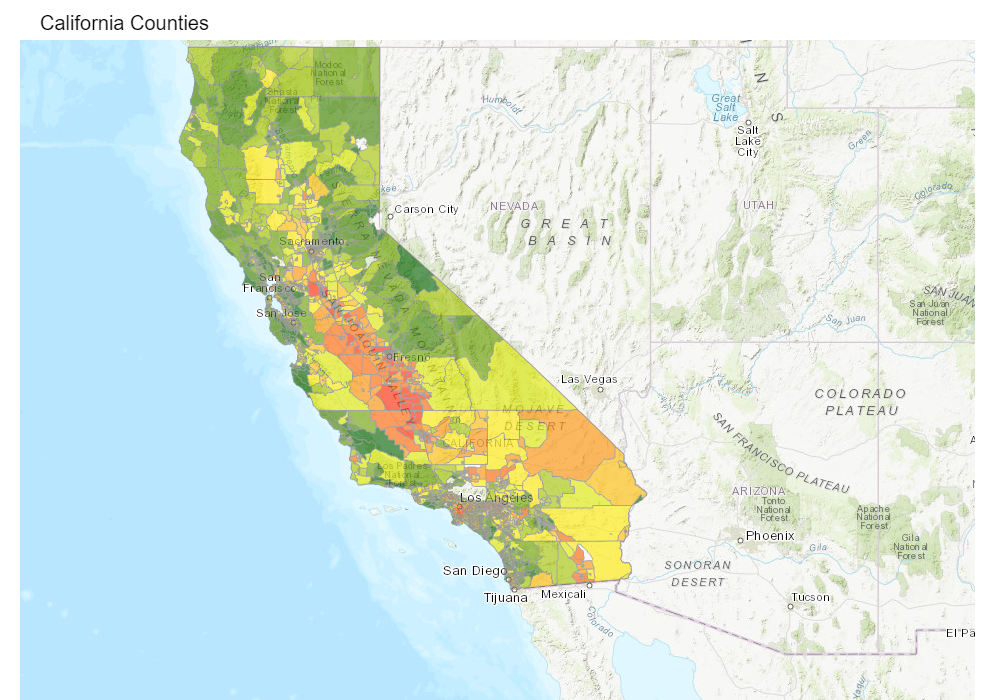


<BR><BR><BR>
This notebook is structed as per below model building approach:<BR>

**Prep the data:**<BR>
1. Read the data dictionary and description from here: 

* https://oehha.ca.gov/media/downloads/calenviroscreen/document/calenviroscreen40resultsdatadictionaryf2021.zip

 Downloaded the data using gdown, read the Excel file using pandas, print the first 10 rows using df.head() and use df.info() to examine the data types and missing values.

2. Simplified the raw dataframe so that you only keep the columns those needed. The `X` variable will be the following columns: `Population`, `Ozone` through `Solid Waste Pctl`, and `Asthma` through `Linguistic Isolation Pctl`. The `y` variable will be `Poverty`. Examined the quality of each column and used my judgement about dropping rows or imputing missing values. Added text cells and lots of comments so you can understand my logic/justification!

3. Recoded the target variable to a 1 if greater than the median value of poverty, otherwise make it a 0. Used this recoded variable as the target variable! Now it is a classification problem.

4. Make few interesting plots and a description of why I made the table and what I saw.

5. Did an 90/10 split for X_train, X_test, y_train, y_test with a random seed to reproduce results at your end again.!

6. Used the StandardScaler() on train and apply to test partition. Did not scale the target variable!
<BR>

**Build, compile and fit the model**<BR>
7. Built a model using the Sequential API with at least 2 dense layers with the relu activation function, and with dropout in between each dense layer (used a number between 0.1 and 0.5). Compiled the model using an appropriate optimizer. Used an early stopping with patience of at least 10 and restored the best weights once the model converges.

8. I fit the model for 100000 epochs with a batch size of 1200, using X_test and y_test as the validation data with the early stopping callback.
<BR>

**Evaluate the model:**<BR>
9. Evaluated the model using learning curves, error metrics and confusion matrices for each partition. 

10. Used logistic regression as a baseline model to compare performance

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Nov  7 16:47:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 - Read Data and Import Modules

## 1.1 Import Libraries

In [ ]:
# import modules
# for general data analysis/plotting
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras 

# for data prep
from sklearn.model_selection import train_test_split

# neural net modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Impute missing values
from sklearn.impute import KNNImputer

#plotty express for plots visuvaliation
import plotly.express as px

#Scaler for normalization
from sklearn.preprocessing import MinMaxScaler

#Model Evaluations
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(
    3001336
)

## 1.2 Import Data

In [ ]:
# https://docs.google.com/spreadsheets/d/1D7VHyrVYNvMpHoQARuqrgZzQ5sHYOMIj/edit?usp=sharing&ouid=115941289972034544975&rtpof=true&sd=true
!gdown --id 1D7VHyrVYNvMpHoQARuqrgZzQ5sHYOMIj # ID for Environmental Health data! look up!
df_CalEnviroScreen = pd.read_excel('calenviroscreen40resultsdatadictionary_F_2021.xlsx')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1D7VHyrVYNvMpHoQARuqrgZzQ5sHYOMIj
To: /content/calenviroscreen40resultsdatadictionary_F_2021.xlsx
100% 5.39M/5.39M [00:00<00:00, 136MB/s]


In [ ]:
# read data
df = pd.read_excel('calenviroscreen40resultsdatadictionary_F_2021.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 58 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Census Tract                 8035 non-null   float64
 1   Total Population             8035 non-null   float64
 2   California County            8035 non-null   object 
 3   ZIP                          8035 non-null   float64
 4   Approximate Location         8035 non-null   object 
 5   Longitude                    8035 non-null   float64
 6   Latitude                     8035 non-null   float64
 7   CES 4.0 Score                7932 non-null   float64
 8    CES 4.0 Percentile          7932 non-null   float64
 9   CES 4.0 Percentile Range     7932 non-null   object 
 10  Ozone                        8035 non-null   float64
 11  Ozone Pctl                   8035 non-null   float64
 12  PM2.5                        8035 non-null   float64
 13  PM2.5 Pctl        

# 2 - Data Cleaning
Shuffle data, split data, minmax normalization

In [ ]:
#shuffle and return all the records
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,Census Tract,Total Population,California County,ZIP,Approximate Location,Longitude,Latitude,CES 4.0 Score,CES 4.0 Percentile,CES 4.0 Percentile Range,...,Linguistic Isolation Pctl,Poverty,Poverty Pctl,Unemployment,Unemployment Pctl,Housing Burden,Housing Burden Pctl,Pop. Char.,Pop. Char. Score,Pop. Char. Pctl
0,6.085505e+09,7769.0,Santa Clara,95134.0,San Jose,-121.943713,37.405414,13.276521,21.217852,20-25%,...,75.774800,9.6,9.271357,3.7,26.861010,9.5,12.002535,29.812281,3.092502,19.742814
1,6.077003e+09,6374.0,San Joaquin,95210.0,Stockton,-121.287041,38.032702,31.646386,61.699445,60-65%,...,58.573555,55.9,88.090452,6.6,63.417491,20.7,65.551331,81.603449,8.464930,94.125063
2,6.037272e+09,4457.0,Los Angeles,90066.0,Los Angeles,-118.427442,34.002110,23.704748,45.940494,45-50%,...,74.759778,32.3,57.437186,4.7,40.603852,14.4,35.272497,43.776360,4.541031,40.809380
3,6.075013e+09,2844.0,San Francisco,94123.0,San Francisco,-122.435681,37.806476,7.290176,7.299546,5-10%,...,35.336311,9.3,8.530151,3.3,21.108798,15.0,38.783270,12.657560,1.313000,2.231467
4,6.073009e+09,7345.0,San Diego,92117.0,San Diego,-117.206765,32.837306,15.129201,25.832073,25-30%,...,NaN,31.2,55.690955,4.7,40.603852,9.9,13.561470,35.945411,3.728707,28.794755


## 2.1 Examine info 

of required columns

In [ ]:
df[['Total Population','Ozone','Ozone Pctl','PM2.5','PM2.5 Pctl','Diesel PM','Diesel PM Pctl','Drinking Water','Drinking Water Pctl','Lead','Lead Pctl','Pesticides','Pesticides Pctl','Tox. Release','Tox. Release Pctl','Traffic','Traffic Pctl','Cleanup Sites','Cleanup Sites Pctl','Groundwater Threats','Groundwater Threats Pctl','Haz. Waste','Haz. Waste Pctl','Imp. Water Bodies','Imp. Water Bodies Pctl','Solid Waste','Solid Waste Pctl','Asthma','Asthma Pctl','Low Birth Weight','Low Birth Weight Pctl','Cardiovascular Disease','Cardiovascular Disease Pctl','Education','Education Pctl','Linguistic Isolation','Linguistic Isolation Pctl','Poverty']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total Population             8035 non-null   float64
 1   Ozone                        8035 non-null   float64
 2   Ozone Pctl                   8035 non-null   float64
 3   PM2.5                        8035 non-null   float64
 4   PM2.5 Pctl                   8035 non-null   float64
 5   Diesel PM                    8035 non-null   float64
 6   Diesel PM Pctl               8035 non-null   float64
 7   Drinking Water               8007 non-null   float64
 8   Drinking Water Pctl          8007 non-null   float64
 9   Lead                         7939 non-null   float64
 10  Lead Pctl                    7939 non-null   float64
 11  Pesticides                   8035 non-null   float64
 12  Pesticides Pctl              8035 non-null   float64
 13  Tox. Release      

## 2.2 Examine null values

Examining only the required columns

In [ ]:
df[['Total Population','Ozone','Ozone Pctl','PM2.5','PM2.5 Pctl','Diesel PM','Diesel PM Pctl','Drinking Water','Drinking Water Pctl','Lead','Lead Pctl','Pesticides','Pesticides Pctl','Tox. Release','Tox. Release Pctl','Traffic','Traffic Pctl','Cleanup Sites','Cleanup Sites Pctl','Groundwater Threats','Groundwater Threats Pctl','Haz. Waste','Haz. Waste Pctl','Imp. Water Bodies','Imp. Water Bodies Pctl','Solid Waste','Solid Waste Pctl','Asthma','Asthma Pctl','Low Birth Weight','Low Birth Weight Pctl','Cardiovascular Disease','Cardiovascular Disease Pctl','Education','Education Pctl','Linguistic Isolation','Linguistic Isolation Pctl','Poverty']].isnull().sum()

Total Population                 0
Ozone                            0
Ozone Pctl                       0
PM2.5                            0
PM2.5 Pctl                       0
Diesel PM                        0
Diesel PM Pctl                   0
Drinking Water                  28
Drinking Water Pctl             28
Lead                            96
Lead Pctl                       96
Pesticides                       0
Pesticides Pctl                  0
Tox. Release                     0
Tox. Release Pctl                0
Traffic                         35
Traffic Pctl                    35
Cleanup Sites                    0
Cleanup Sites Pctl               0
Groundwater Threats              0
Groundwater Threats Pctl         0
Haz. Waste                       0
Haz. Waste Pctl                  0
Imp. Water Bodies                0
Imp. Water Bodies Pctl           0
Solid Waste                      0
Solid Waste Pctl                 0
Asthma                          11
Asthma Pctl         

## 2.3 Address null values & Input/Ouput Assignment

### 2.3.1 Pertaining to Y matrix data


#### 2.3.1.1 Drop missing records

In [ ]:
# dropping the records having null values for the output column
# asigning Y after dropping the records, so as to ease the creation of X matrix later on (to align the records count)
df = df.dropna(axis=0, subset=['Poverty'])
df.reset_index(drop=True, inplace=True)

In [ ]:
# checking the result
df[['Total Population','Ozone','Ozone Pctl','PM2.5','PM2.5 Pctl','Diesel PM','Diesel PM Pctl','Drinking Water','Drinking Water Pctl','Lead','Lead Pctl','Pesticides','Pesticides Pctl','Tox. Release','Tox. Release Pctl','Traffic','Traffic Pctl','Cleanup Sites','Cleanup Sites Pctl','Groundwater Threats','Groundwater Threats Pctl','Haz. Waste','Haz. Waste Pctl','Imp. Water Bodies','Imp. Water Bodies Pctl','Solid Waste','Solid Waste Pctl','Asthma','Asthma Pctl','Low Birth Weight','Low Birth Weight Pctl','Cardiovascular Disease','Cardiovascular Disease Pctl','Education','Education Pctl','Linguistic Isolation','Linguistic Isolation Pctl','Poverty']].isnull().sum()

Total Population                 0
Ozone                            0
Ozone Pctl                       0
PM2.5                            0
PM2.5 Pctl                       0
Diesel PM                        0
Diesel PM Pctl                   0
Drinking Water                   2
Drinking Water Pctl              2
Lead                            24
Lead Pctl                       24
Pesticides                       0
Pesticides Pctl                  0
Tox. Release                     0
Tox. Release Pctl                0
Traffic                         26
Traffic Pctl                    26
Cleanup Sites                    0
Cleanup Sites Pctl               0
Groundwater Threats              0
Groundwater Threats Pctl         0
Haz. Waste                       0
Haz. Waste Pctl                  0
Imp. Water Bodies                0
Imp. Water Bodies Pctl           0
Solid Waste                      0
Solid Waste Pctl                 0
Asthma                           0
Asthma Pctl         

In [ ]:
df['Poverty']

0        9.6
1       55.9
2       32.3
3        9.3
4       31.2
        ... 
7955    19.0
7956    38.7
7957    56.6
7958    39.8
7959    29.3
Name: Poverty, Length: 7960, dtype: float64

In [ ]:
median = df['Poverty'].median()

#### 2.3.1.2 Encoding 'Poverty' based on median

In [ ]:
for i in range(0,(df['Poverty'].count())):
  if df['Poverty'][i] < median:
    df['Poverty'][i] = 0
  else:
    df['Poverty'][i] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# ensuring proper encoding
df.loc[df['Poverty'] == 0]['Poverty']

0       0.0
3       0.0
5       0.0
7       0.0
9       0.0
       ... 
7945    0.0
7946    0.0
7950    0.0
7951    0.0
7955    0.0
Name: Poverty, Length: 3958, dtype: float64

#### 2.3.1.3 Assign y

In [ ]:
y_before_nparray = df['Poverty']

In [ ]:
y = np.array(y_before_nparray)
y

array([0., 1., 1., ..., 1., 1., 1.])

In [ ]:
y.shape

(7960,)

In [ ]:
print(y[0:20])

[0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.]


### 2.3.2 Pertaining to X matrix data

#### 2.3.2.1 Set input X_before_imputing

As per the data dictionary, null vlues in the raw data no monitoring or reporting was conducted. 
Null values in the corespondng percentile values are ignored for calculating the CalEnviroScreen score. 

Therefoe, both the raw and pecentil values can be imputed.

Insead of mean imputation, attempting knn imputer to restrict the skewness that could arise from mean/median imputation.

In [ ]:
X_before_imputing = df[['Total Population','Ozone','Ozone Pctl','PM2.5','PM2.5 Pctl','Diesel PM','Diesel PM Pctl','Drinking Water','Drinking Water Pctl','Lead','Lead Pctl','Pesticides','Pesticides Pctl','Tox. Release','Tox. Release Pctl','Traffic','Traffic Pctl','Cleanup Sites','Cleanup Sites Pctl','Groundwater Threats','Groundwater Threats Pctl','Haz. Waste','Haz. Waste Pctl','Imp. Water Bodies','Imp. Water Bodies Pctl','Solid Waste','Solid Waste Pctl','Asthma','Asthma Pctl','Low Birth Weight','Low Birth Weight Pctl','Cardiovascular Disease','Cardiovascular Disease Pctl','Education','Education Pctl','Linguistic Isolation','Linguistic Isolation Pctl']]

In [ ]:
X_before_imputing

,Total Population,Ozone,Ozone Pctl,PM2.5,PM2.5 Pctl,Diesel PM,Diesel PM Pctl,Drinking Water,Drinking Water Pctl,Lead,...,Asthma,Asthma Pctl,Low Birth Weight,Low Birth Weight Pctl,Cardiovascular Disease,Cardiovascular Disease Pctl,Education,Education Pctl,Linguistic Isolation,Linguistic Isolation Pctl
0,7769.0,0.038092,16.776602,8.381512,19.863099,0.287032,75.034225,314.085409,29.037093,11.335092,...,22.80,12.911266,5.00,52.360790,11.01,37.873878,1.1,2.303214,14.4,75.774800
1,6374.0,0.045884,44.978220,10.964234,54.623522,0.085870,31.985065,616.162239,69.476708,38.013744,...,81.55,86.029412,7.41,93.199897,24.51,97.357926,29.3,79.422931,9.2,58.573555
2,4457.0,0.045393,42.563783,11.633171,63.995022,0.163945,54.723086,440.638034,52.716373,56.992480,...,35.21,33.823529,3.02,9.507313,12.29,48.629113,27.1,76.423690,14.1,74.759778
3,2844.0,0.029372,3.123833,8.735282,31.113877,0.816702,96.938395,258.789440,15.036843,54.350040,...,15.19,4.012961,2.46,4.182705,5.89,2.966102,1.6,4.214123,4.6,35.336311
4,7345.0,0.044902,39.987554,9.378283,42.962041,0.110155,40.448040,312.860703,28.987136,60.292290,...,37.27,36.901795,4.56,40.107775,9.60,26.221336,9.5,40.065806,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,3640.0,0.047920,53.727442,8.154848,15.631612,0.161843,54.125700,342.908549,35.306607,47.202860,...,43.15,46.311067,4.23,31.998974,12.21,47.619641,8.2,35.218932,3.2,25.551495
7956,4350.0,0.057631,76.938395,11.878311,72.383323,0.278124,74.026136,702.691204,77.869364,75.713667,...,46.30,50.997009,6.60,85.026944,10.90,37.001496,35.7,85.927613,18.9,84.896468
7957,3356.0,0.043205,32.146857,12.094910,84.044804,0.130991,46.135657,787.940335,92.531535,87.309930,...,128.21,97.021436,6.03,75.763408,21.69,92.883848,50.4,96.659074,8.4,55.149547
7958,4862.0,0.050230,62.526447,12.128322,86.148102,0.128539,45.438706,320.452394,30.036218,72.767936,...,57.34,66.026919,4.45,37.233770,17.79,79.885344,34.8,85.079727,23.6,90.918934


In [ ]:
X_before_imputing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7960 entries, 0 to 7959
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Total Population             7960 non-null   float64
 1   Ozone                        7960 non-null   float64
 2   Ozone Pctl                   7960 non-null   float64
 3   PM2.5                        7960 non-null   float64
 4   PM2.5 Pctl                   7960 non-null   float64
 5   Diesel PM                    7960 non-null   float64
 6   Diesel PM Pctl               7960 non-null   float64
 7   Drinking Water               7958 non-null   float64
 8   Drinking Water Pctl          7958 non-null   float64
 9   Lead                         7936 non-null   float64
 10  Lead Pctl                    7936 non-null   float64
 11  Pesticides                   7960 non-null   float64
 12  Pesticides Pctl              7960 non-null   float64
 13  Tox. Release      

#### 2.3.2.2 Impute and asign X

In [ ]:
# create object for KNNImputer
imputer = KNNImputer(n_neighbors=3)
X = imputer.fit_transform(X_before_imputing) #Fit and Transform X with KNN imputation

In [ ]:
# checking the output overview
X

array([[7.76900000e+03, 3.80921700e-02, 1.67766024e+01, ...,
        2.30321438e+00, 1.44000000e+01, 7.57748004e+01],
       [6.37400000e+03, 4.58836800e-02, 4.49782203e+01, ...,
        7.94229309e+01, 9.20000000e+00, 5.85735553e+01],
       [4.45700000e+03, 4.53928500e-02, 4.25637834e+01, ...,
        7.64236902e+01, 1.41000000e+01, 7.47597780e+01],
       ...,
       [3.35600000e+03, 4.32051300e-02, 3.21468575e+01, ...,
        9.66590737e+01, 8.40000000e+00, 5.51495466e+01],
       [4.86200000e+03, 5.02296200e-02, 6.25264468e+01, ...,
        8.50797267e+01, 2.36000000e+01, 9.09189335e+01],
       [5.28400000e+03, 5.53028800e-02, 7.25451151e+01, ...,
        4.34067325e+01, 2.83000000e+01, 9.47895520e+01]])

In [ ]:
X.shape

(7960, 37)

# 3 - Plot Analysis

**Creating DF2 using X array (after KNN imputing) and Y array for plot visuvalizations**

In [ ]:
df2 = pd.DataFrame(X)
df2.columns = ['Total Population','Ozone','Ozone Pct1','PM2.5','PM2.5 Pct1','Diesel PM','Diesel PM Pct1','Drinking Water','Drinking Water Pct1','Lead','Lead Pct1','Pesticides','Pesticides Pct1','Tox. Release','Tox. Release Pct1','Traffic','Traffic Pct1','Cleanup Sites','Cleanup Sites Pct1','Groundwater Threats','Groundwater Threats Pct1','Haz. Waste','Haz. Waste Pct1','Imp. Water Bodies','Imp. Water Bodies Pct1','Solid Waste','Solid Waste Pct1','Asthma','Asthma Pct1','Low Birth Weight','Low Birth Weight Pct1','Cardiovascular Disease','Cardiovascular Disease Pct1','Education','Education Pct1','Linguistic Isolation','Linguistic Isolation Pct1']
df2['Poverty'] = df['Poverty']

In [ ]:
df2

,Total Population,Ozone,Ozone Pct1,PM2.5,PM2.5 Pct1,Diesel PM,Diesel PM Pct1,Drinking Water,Drinking Water Pct1,Lead,...,Asthma Pct1,Low Birth Weight,Low Birth Weight Pct1,Cardiovascular Disease,Cardiovascular Disease Pct1,Education,Education Pct1,Linguistic Isolation,Linguistic Isolation Pct1,Poverty
0,7769.0,0.038092,16.776602,8.381512,19.863099,0.287032,75.034225,314.085409,29.037093,11.335092,...,12.911266,5.00,52.360790,11.01,37.873878,1.1,2.303214,14.4,75.774800,0.0
1,6374.0,0.045884,44.978220,10.964234,54.623522,0.085870,31.985065,616.162239,69.476708,38.013744,...,86.029412,7.41,93.199897,24.51,97.357926,29.3,79.422931,9.2,58.573555,1.0
2,4457.0,0.045393,42.563783,11.633171,63.995022,0.163945,54.723086,440.638034,52.716373,56.992480,...,33.823529,3.02,9.507313,12.29,48.629113,27.1,76.423690,14.1,74.759778,1.0
3,2844.0,0.029372,3.123833,8.735282,31.113877,0.816702,96.938395,258.789440,15.036843,54.350040,...,4.012961,2.46,4.182705,5.89,2.966102,1.6,4.214123,4.6,35.336311,0.0
4,7345.0,0.044902,39.987554,9.378283,42.962041,0.110155,40.448040,312.860703,28.987136,60.292290,...,36.901795,4.56,40.107775,9.60,26.221336,9.5,40.065806,6.5,40.185862,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7955,3640.0,0.047920,53.727442,8.154848,15.631612,0.161843,54.125700,342.908549,35.306607,47.202860,...,46.311067,4.23,31.998974,12.21,47.619641,8.2,35.218932,3.2,25.551495,0.0
7956,4350.0,0.057631,76.938395,11.878311,72.383323,0.278124,74.026136,702.691204,77.869364,75.713667,...,50.997009,6.60,85.026944,10.90,37.001496,35.7,85.927613,18.9,84.896468,1.0
7957,3356.0,0.043205,32.146857,12.094910,84.044804,0.130991,46.135657,787.940335,92.531535,87.309930,...,97.021436,6.03,75.763408,21.69,92.883848,50.4,96.659074,8.4,55.149547,1.0
7958,4862.0,0.050230,62.526447,12.128322,86.148102,0.128539,45.438706,320.452394,30.036218,72.767936,...,66.026919,4.45,37.233770,17.79,79.885344,34.8,85.079727,23.6,90.918934,1.0


## 3.1 Education Vs Poverty

In [ ]:
fig = px.box(df2, y="Education", x="Poverty", title = 'Percent of population over 25 with less than a high school education Vs Poverty', color = 'Poverty')
fig.update_traces(quartilemethod="exclusive")
fig.show()

**Rationale of plot:** <br>
Poverty is usually associated with Human Development Index which is associated with education parameter. Poverty and unawarenss due to uneducation can further contribute to various pollutions.<br><br>


**Notes:** <br>
Poverty in the dataset is the percent of population living below two times the federal poverty level. The data is encoded such that those with poverty percent higher than median is 1, otherwise 0. Thereby after encoding, we can assume that 1 indicates it is a poverty region and 0 indicates it is a non-poverty region.<br><br>

**Interpretation:**<br>
* Amongst non-poverty regions, about 50% of the regions has about 7% of uneducated youth. Where as in poverty regions, 50% of regions has uneducated youth of about 16%. (25th - 75th percentile) <BR>
* Also, In non-poverty regions, the maximum percent of uneducated population is 21.6%. Therefore, looking at the plot, we can clearly state that if any cencus tract has uneducated percent more than 21.6%, it is bound to become a poverty region.<BR><BR>


## 3.2 Risk for lead exposure Vs Cardiovascular Diseases Vs Pesticide Presence

In [ ]:
# Creating new column for encoding presence of selected active pesticide ingredients
df2['pest_code'] = 0

In [ ]:
# encoding to '1' if presence of pesticides identified, '0' if un-identified
for i in range(0, df2['Pesticides'].count()):
  if df2['Pesticides'][i] > 0:
    df2['pest_code'][i] = 1
  else:
    df2['pest_code'][i] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
fig = px.scatter(df2, y="Cardiovascular Disease", x="Lead", color='pest_code', title = 'Heart Diseases Vs Lead Vs Pesticide Presence')
fig.show()

**Rationale of plot:**<br>
* Lead is a hazardous chemical and is associated with heart diseases (https://ehp.niehs.nih.gov/doi/10.1289/ehp.9785). <BR>
* Unregulated lead presence in pesticides (thereby in soil) can lead to heath issues like cancer (https://oehha.ca.gov/chemicals/lead-phosphate)
* Therefore the above scatter plot aims to study the correlation between potential risk to lead exposure and rate of emergency department visits for heart attacks in a region, together with the presence of pesticides.<BR>

**Notes:**<BR>
Presence of pesticides is encoded into 'pest_code" variable. It is encoded to '1' if there is presence of pesticides, '0' if not presence. <BR>

**Intepretation:**<BR>
We can infer that the higher risk exposure to lead, the higher risk of having cardiovascualr diseases. Especially if the lead risk is more than 60, the risk of heart attacks is slightly exponentially correlated.<BR>
Also, we can observe that pesticide presence is not giving a higher risk exposure to lead, indicating the lead levels are probably regulated in the pesticide usage.<BR>
However, in those regions where lead exposure is more than 60, there could be some other parameter other than pesticide linked to elevated lead risk which needs further investigation.<BR><BR>







# 4 - Prepare Data for model

## 4.1 Split into X_train, X_test, y_train, y_test 90/10

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.1,
                                                    shuffle = True,
                                                    random_state = 3001336)

## 4.2 Scaling the data using MinMaxScaler()

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5 - Building the Model

In [ ]:
# keras.backend.clear_session()

In [ ]:
model = Sequential()
model.add(Dense(8, input_shape=(X_train.shape[1],), activation='relu')) # first hidden layer
model.add(Dropout(0.1))
model.add(Dense(5, activation='relu')) #Second hidden layer
model.add(Dropout(0.2))
# model.add(Dense(2, activation='relu')) #Third hidden layer
# model.add(Dropout(0.3))
# # model.add(Dense(10, activation='relu')) #Third hidden layer
# # model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) #Output layer; continous output; linear activation
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 304       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 5)                 45        
                                                                 
 dropout_1 (Dropout)         (None, 5)                 0         
                                                                 
 dense_2 (Dense)             (None, 1)                 6         
                                                                 
Total params: 355
Trainable params: 355
Non-trainable params: 0
_________________________________________________________________


# 6 - Compile the model

In [ ]:
# model.compile(optimizer='rmsprop', 
#               loss='binary_crossentropy', 
#               metrics=['accuracy'])

In [ ]:
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 7 - Fit the model

In [ ]:
# keras.backend.clear_session()

## 7.1 Early stopping

In [ ]:
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max',
                                   patience=500,
                                   restore_best_weights=True)

## 7.2 Fit the model

In [ ]:
history = model.fit(X_train, y_train,
                    callbacks=[es],
                    epochs=100000,
                    batch_size=1200,
                    validation_data =(X_test, y_test),
                    shuffle=True,
                    verbose=1)

Epoch 1/100000
6/6 [==============================] - 4s 36ms/step - loss: 0.7133 - accuracy: 0.5014 - val_loss: 0.6952 - val_accuracy: 0.5113
Epoch 2/100000
6/6 [==============================] - 0s 6ms/step - loss: 0.7058 - accuracy: 0.5078 - val_loss: 0.6880 - val_accuracy: 0.5113
Epoch 3/100000
6/6 [==============================] - 0s 7ms/step - loss: 0.6948 - accuracy: 0.5296 - val_loss: 0.6801 - val_accuracy: 0.5465
Epoch 4/100000
6/6 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.5426 - val_loss: 0.6716 - val_accuracy: 0.6005
Epoch 5/100000
6/6 [==============================] - 0s 7ms/step - loss: 0.6763 - accuracy: 0.5684 - val_loss: 0.6623 - val_accuracy: 0.6231
Epoch 6/100000
6/6 [==============================] - 0s 6ms/step - loss: 0.6734 - accuracy: 0.5692 - val_loss: 0.6529 - val_accuracy: 0.6508
Epoch 7/100000
6/6 [==============================] - 0s 7ms/step - loss: 0.6612 - accuracy: 0.5945 - val_loss: 0.6433 - val_accuracy: 0.6784
Epoch

# 8 - Model Evaluation

## 8.1 Epochs Vs Accuracy

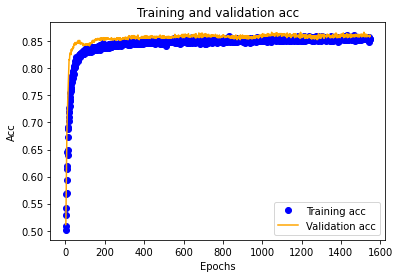

In [ ]:
history_dict = history.history
loss_values = history_dict['accuracy'] 
val_loss_values = history_dict['val_accuracy'] 
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label='Training acc')
plt.plot(epochs, val_loss_values, 'orange', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

**Observations:**<BR>
*   The model is not overfit to training. Accuracy on test data was better than compared on training.<BR><BR>
*   The model seems to attain around 84% accuracy by around 40 epochs and  improved accuracy very little thereafter.<BR><BR>
*   This dataset took lot of fine tuning for the model to converge and not to be overfit. I tried models both with trainable paramters as high as 2500-5000 and as low as 100-200. In either cases, the models are overfit to training.<BR><BR> 
*   I observed that for this dataset, with a higher batch size and lower patience level, the accuracy got better. <BR><BR>






## 8.2 Epochs Vs Loss

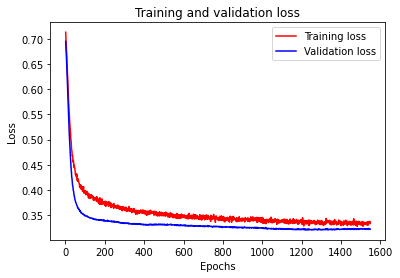

In [ ]:
# learning curve
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
# loss
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

**Observations:**<BR>

*   The error almost convereged by aorund 40 epochs with test data and there is little improvement thereafter. <BR><BR>
*   However, with the training data the model kept improving on the error till the last epoch it ran.<BR><BR>



## 8.3 Predictions

In [ ]:
model.predict(X)

249/249 [==============================] - 0s 1ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
np.round(model.predict(X),0)

249/249 [==============================] - 0s 1ms/step


array([[0.],
       [0.],
       [0.],
       ...,
       [1.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
y

array([0., 1., 1., ..., 1., 1., 1.])

## 8.4 Confusion Matrix

In [ ]:
preds = np.round(model.predict(X_test),0)

# confusion matrix
confusion_matrix(y_test, preds)
# TP is bottom right
# TN is top left
# FP is top right
# FN is bottom left

25/25 [==============================] - 0s 1ms/step


array([[346,  39],
       [ 67, 344]])

In [ ]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       385
         1.0       0.90      0.84      0.87       411

    accuracy                           0.87       796
   macro avg       0.87      0.87      0.87       796
weighted avg       0.87      0.87      0.87       796



# 9 - Baseline Model - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
from pandas.core.common import random_state
lr = LogisticRegression(C=1000.0, random_state = 3001336)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
from sklearn.metrics import accuracy_score
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

Accuracy: 0.85


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.82      0.88      0.85       385
         1.0       0.88      0.82      0.85       411

    accuracy                           0.85       796
   macro avg       0.85      0.85      0.85       796
weighted avg       0.85      0.85      0.85       796



# 10 - Observations, Insights and Comments about Model Performance

* The FNN model has better accuracy at 87% while logistic regression achieved 85%

* The FNN model also has beter recall and precision values comapred to logistic regression.

* F-1 score is higher for neural network, indicating that the features used for the FNN modelling are lkely sufficient for classification. 